# Social Network Analysis

In [2]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# conformance
from pm4py.algo.conformance.footprints import algorithm as fp_conformance
from pm4py import conformance_diagnostics_token_based_replay
from pm4py.algo.conformance.alignments.edit_distance import algorithm as logs_alignments

# misc 
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.petri_net.obj import PetriNet, Marking

import pm4py

In [75]:
events_array = [[1, "Bestellen", pd.to_datetime("01/01/1970"),"Sue"],
          [1, "Servieren", pd.to_datetime("01/02/1970"),"Alan"],
          [1, "Kassieren", pd.to_datetime("01/03/1970"),"Sara"],
          [2, "Bestellen", pd.to_datetime("01/01/1970"),"Cara"],
          [2, "Servieren", pd.to_datetime("01/02/1970"),"Alan"],
          [2, "Kassieren", pd.to_datetime("01/03/1970"),"Sara"],
          ]

In [76]:
events = pd.DataFrame(events_array, columns=[ 'case:concept:name', 'concept:name', 'time:timestamp', 'org:resource'])

In [77]:
log = log_converter.apply(events)

In [78]:
# footprint
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery
footprint = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
footprint['sequence']




{('Bestellen', 'Servieren'), ('Servieren', 'Kassieren')}

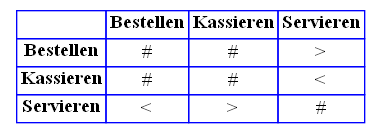

In [79]:
from pm4py.visualization.footprints import visualizer as fp_visualizer

gviz = fp_visualizer.apply(footprint)
fp_visualizer.view(gviz)

In [80]:
hw_values = pm4py.discover_handover_of_work_network(log, beta=0)

In [81]:
hw_values

[array([[0.  , 0.  , 0.5 , 0.  ],
        [0.25, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.25, 0.  , 0.  , 0.  ]]),
 ['Alan', 'Cara', 'Sara', 'Sue'],
 True]

In [82]:
pd.DataFrame(hw_values[0], index=hw_values[1], columns=hw_values[1])

,Alan,Cara,Sara,Sue
Alan,0.00,0.0,0.5,0.0
Cara,0.25,0.0,0.0,0.0
Sara,0.00,0.0,0.0,0.0
Sue,0.25,0.0,0.0,0.0


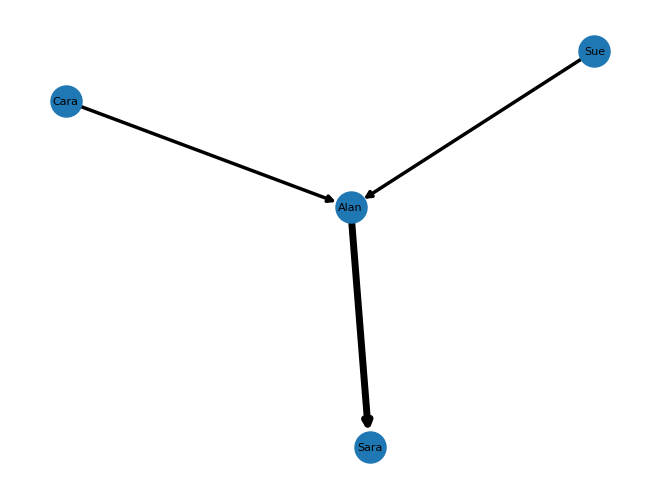

In [87]:
# depict distances as network with networkx
import networkx as nx
G_hw = nx.from_numpy_array(hw_values[0], create_using=nx.DiGraph)
G_hw = nx.relabel_nodes(G_hw, dict(zip(range(len(hw_values[1])), hw_values[1])))
mywidth = [i * 10 for i in list(nx.get_edge_attributes(G_hw,'weight').values())]
nx.draw(G_hw, with_labels=True, node_size=500, font_size=8, width=mywidth)


In [88]:
# degree centrality for edges in G_hw that ignores edge weights
nx.degree_centrality(G_hw)

{'Alan': 1.0,
 'Cara': 0.3333333333333333,
 'Sara': 0.3333333333333333,
 'Sue': 0.3333333333333333}

In [89]:
# degree centrality for edges in G_hw considering edge weights
G_hw.degree(weight='weight')

DiDegreeView({'Alan': 1.0, 'Cara': 0.25, 'Sara': 0.5, 'Sue': 0.25})

In [90]:
# add distance attribute to G_hw
g_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G_hw.edges(data='weight')}
nx.set_edge_attributes(G_hw, g_distance_dict, 'distance')

In [95]:
nx.betweenness_centrality(G_hw, weight='distance', normalized=False)

{'Alan': 2.0, 'Cara': 0.0, 'Sara': 0.0, 'Sue': 0.0}

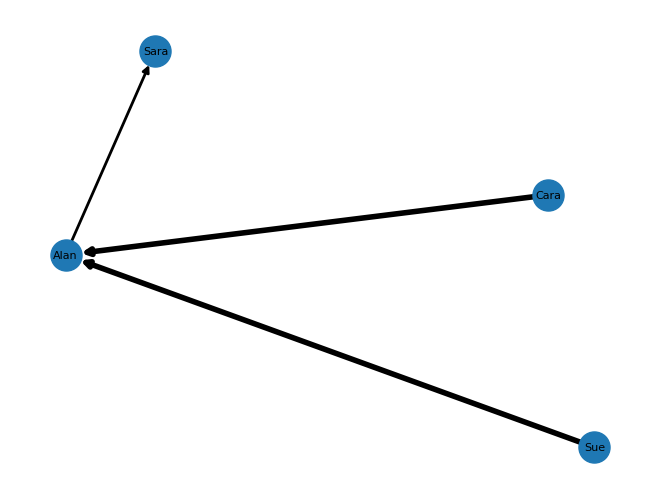

In [94]:
mydistance = [i  for i in list(nx.get_edge_attributes(G_hw,'distance').values())]
nx.draw(G_hw, with_labels=True, node_size=500, font_size=8, width=mydistance)